# Keras 창시자에게 배우는 딥러닝

## 데이터 내려받기 테스트
- 캐글 이미지 데이터를 구글 코랩으로 불러오기
- (API) 통해서 불러오기

In [33]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"foodgoon","key":"51cf808f8fdfe72a9ddcee186051dea4"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 2.35MB/s]


In [5]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


- p.282 합성곱 신경망 소개

## 간단한 합성곱 만들기
- 합성곱 층과 MaxPooling 층을 연달아서 쌓아 올림

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1)) # 입력층 만듬, Input < i 대문자

# 합성곱 층, filters = 깊이
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs) # 함수형 API
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

# 출력층
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

## MNIST 이미지 합성곱 훈련
- 2장의 연결 네트워크는 97.8%

In [8]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/5
938/938 [==============================] - 16s 5ms/step - loss: 0.1592 - accuracy: 0.9510
Epoch 2/5
938/938 [==============================] - 5s 6ms/step - loss: 0.0452 - accuracy: 0.9863
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0311 - accuracy: 0.9904
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0242 - accuracy: 0.9926
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0185 - accuracy: 0.9945


In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0251 - accuracy: 0.9918
0.9918000102043152


## p.292
- 최대 폴링 층이 빠진 잘못된 구조의 합성곱
  + 가장 큰 문제점 : 이미지 압축이 안됨

In [10]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## 개와 고양이 이미지 다운로드

In [12]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:23<00:00, 40.7MB/s]
100% 812M/812M [00:23<00:00, 36.5MB/s]


In [13]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [14]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

## 모델 만들기

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3)) # 180x180 크기의 RGB 이미지를 기대함.
x = layers.Rescaling(1./255)(inputs) # 입력을 255로 나누어 [0, 1] 범위의 스케일 조정
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [17]:
model.compile(loss ="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## 데이터 전처리
- p. 301

In [18]:
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 텐서플로 Dataset 객체 이해하기
- 샘플 데이터 1000개 만들기

In [19]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

- 하나의 샘플 확인하기

In [20]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


- 데이터 배치

In [21]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


- 원소 크기를 (16, 0) -> (4, 4)

In [22]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


### Dataset이 반환하는 데이터 및 레이블 크기 확인

In [23]:
for data_batch, labels_batch in train_dataset:
  print("데이터 배치 크기", data_batch.shape)
  print("레이블 배치 크기", labels_batch.shape)
  break

데이터 배치 크기 (32, 180, 180, 3)
레이블 배치 크기 (32,)


### 모델 훈련하기

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True, # 1epoch vs 2epoch
        monitor="val_loss")  #
]

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/30
63/63 [==============================] - 9s 93ms/step - loss: 0.6934 - accuracy: 0.5190 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6840 - accuracy: 0.5520 - val_loss: 0.6546 - val_accuracy: 0.6280
Epoch 3/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6396 - accuracy: 0.6395 - val_loss: 0.6452 - val_accuracy: 0.6220
Epoch 4/30
63/63 [==============================] - 6s 91ms/step - loss: 0.5991 - accuracy: 0.6820 - val_loss: 0.6422 - val_accuracy: 0.6460
Epoch 5/30
63/63 [==============================] - 5s 83ms/step - loss: 0.5810 - accuracy: 0.7045 - val_loss: 0.6286 - val_accuracy: 0.6650
Epoch 6/30
63/63 [==============================] - 4s 64ms/step - loss: 0.5467 - accuracy: 0.7265 - val_loss: 0.6321 - val_accuracy: 0.6720
Epoch 7/30
63/63 [==============================] - 5s 74ms/step - loss: 0.5152 - accuracy: 0.7420 - val_loss: 0.5650 - val_accuracy: 0.7320
Epoch 8/30
63

In [25]:
import matplotlib.pyplot as plt
def check_train_val_plot(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
  ax[0].plot(epochs, accuracy, "bo", label="Training accuracy")
  ax[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
  ax[0].set_title("Training and validation accuracy")
  ax[0].legend()
  ax[1].plot(epochs, loss, "bo", label="Training loss")
  ax[1].plot(epochs, val_loss, "b", label="Validation loss")
  ax[1].set_title("Training and validation loss")
  ax[1].legend()
  plt.show()

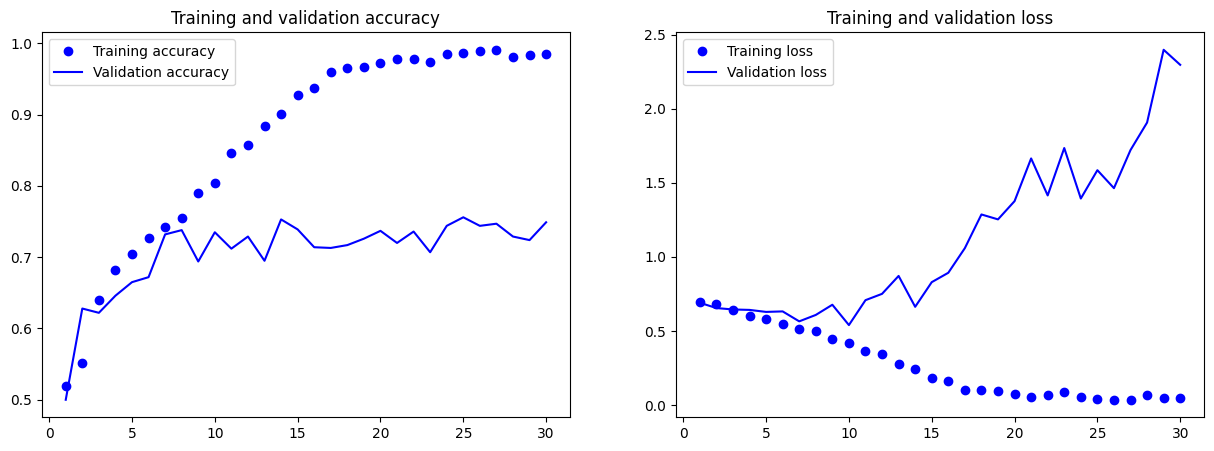

In [26]:
check_train_val_plot(history)

### 테스트 모델에서 모델평가

In [27]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 5s 68ms/step - loss: 0.5832 - accuracy: 0.7205
테스트 정확도: 0.720


### 데이터 증식 사용
- https://opencv.org/
- https://albumentations.ai/

In [28]:
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])

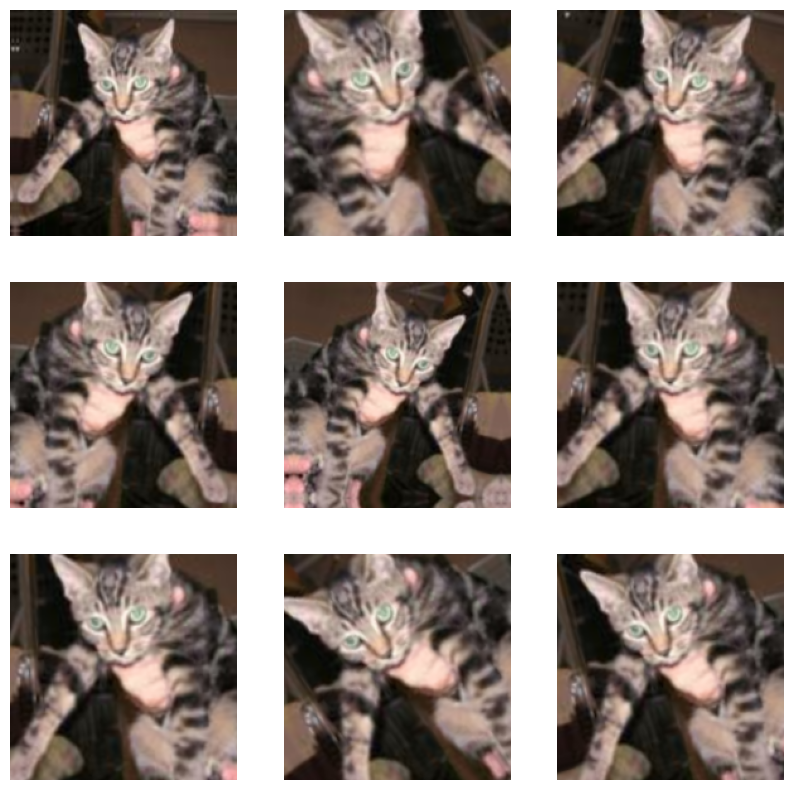

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [30]:
inputs = keras.Input(shape=(180, 180, 3)) # 입력층
x = data_augmentation(inputs)             # 데이터 증식 단계 통과 시킴
x = layers.Rescaling(1./255)(x)           # 이미지 [0, 1]

# 은닉층
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)                # 드롭아웃을 적용하면 과대적합이 덜 일어난다.

# 출력층
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [31]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True, # 1epoch vs 2epoch
        monitor="val_loss")  #
]

history = model.fit(
    train_dataset,
    epochs=5,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/5
63/63 [==============================] - 7s 103ms/step - loss: 0.5801 - accuracy: 0.6950 - val_loss: 0.5955 - val_accuracy: 0.6660
Epoch 2/5
63/63 [==============================] - 6s 90ms/step - loss: 0.5639 - accuracy: 0.7195 - val_loss: 0.5341 - val_accuracy: 0.7210
Epoch 3/5
63/63 [==============================] - 5s 69ms/step - loss: 0.5554 - accuracy: 0.7215 - val_loss: 0.6191 - val_accuracy: 0.6800
Epoch 4/5
63/63 [==============================] - 8s 111ms/step - loss: 0.5381 - accuracy: 0.7335 - val_loss: 0.5114 - val_accuracy: 0.7400
Epoch 5/5
63/63 [==============================] - 6s 90ms/step - loss: 0.5284 - accuracy: 0.7375 - val_loss: 0.5473 - val_accuracy: 0.7320


### 테스트 세트에서 모델 정확도 확인

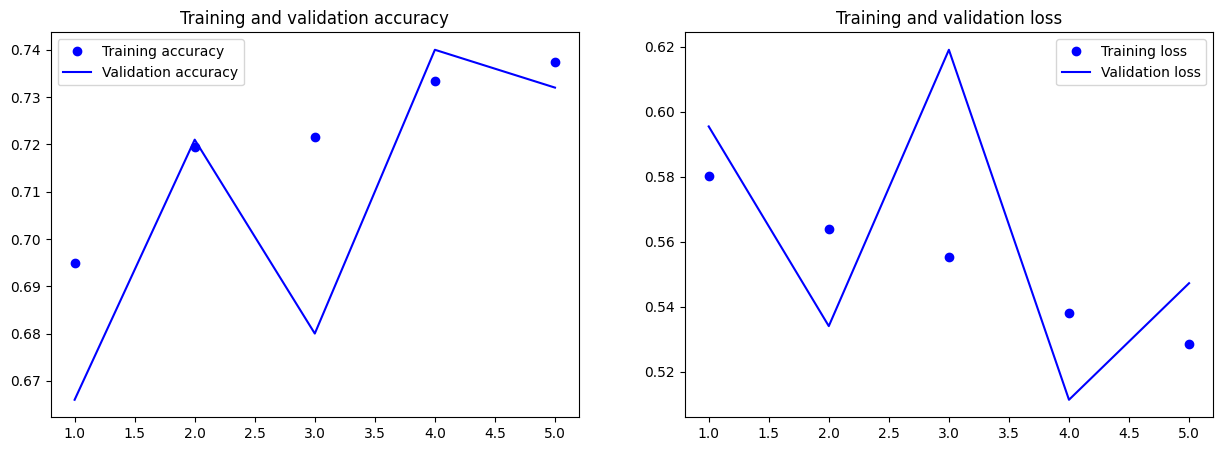

In [35]:
check_train_val_plot(history)

In [36]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras") # 저장된 모델 불러오기
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 3s 35ms/step - loss: 0.5456 - accuracy: 0.7345
테스트 정확도: 0.734


## 사전 훈련됨 모델
- 일반 정확도 68.8%
- 데이터 증식 정확도 : 83.8%
- 사전 훈련된 모델 : 97.5%
- 모델 미세 조정하기 : 98.5
- 결론 : 딥러닝 프로젝트,
  + 주요 키워드 --> 사전 훈련된 모델 & 모델 미세 조정하기
  + Chat GPT 샘플 코드 요청

## 머신러닝 프로젝트 vs 딥러닝 프로젝트
- 머신러닝 프로젝트의 핵심은 정확도 + 변수 추출 과정 설명 중요
  + 데이터분석가 지망생들이 많이 함
- 딥러닝 프로젝트의 핵심은 정확도 + 어떤 모델 썼느냐 ! 모델에 대한 설명(영어 논문 또는 한글로 번역한 유튜브 공부!)
  + 컴공 출신들이 많이 함

## 사전 훈련된 모델 활용 p.311
- pretrained model
- https://paperswithcode.com/paper/very-deep-convolutional-networks-for-large
- https://arxiv.org/pdf/1905.11946.pdf

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


- p.312
- 훈련된 합성곱 기반 층 (동결)
  + vgg16에서 정의된 구조를 그대로 이어받아서 사용하겠다.
- ImageNet 데이터셋에서 훈련했다! ==> 대용량 & 다양한 이미지를 학습했다.

In [38]:
# 2014년에 제안된 모델
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top = False,
    input_shape = (180, 180, 3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [39]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### 특성 추출
- 데이터 증식을 사용하지 않는 특성 추출

In [45]:
# predict() 메서드 호출 넘파이 배열로 특성을 추출
def get_features_and_labels(dataset):
  all_features = [] # 특성
  all_labels = [] # 각 특성에 맞는 label
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)

  return np.concatenate(all_features), np.concatenate(all_labels)

In [46]:
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (180, 180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (180, 180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [47]:
from keras.applications import VGG16
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

train_features.shape, train_labels.shape

1/1 [==============================] - 0s 21ms/step


((2000, 5, 5, 512), (2000,))

In [48]:
val_features.shape, val_labels.shape

((1000, 5, 5, 512), (1000,))

In [49]:
test_features.shape, test_labels.shape

((2000, 5, 5, 512), (2000,))

In [50]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
features

1/1 [==============================] - 1s 733ms/step


array([[[[59.09735  ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [42.572563 ,  0.       ,  3.1530623, ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       , 18.166334 , ...,  0.       ,
           0.       ,  9.990405 ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  4.5960965],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[30.416332 ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       , 21.980013 , ...,  0.       ,
           0.       ,  0.       ],
         [13.314047 ,  0.       ,  3.0975986, ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [33.983784 ,  0.       ,  0.       , ..., 10.769696 ,
           0.       , 13.

### 출력층 정의하고 재훈련

In [54]:
# 상단에 vgg16 이 있고, 여기 출력층이 5, 5, 512
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs) # Dense 특성 주입하기 전에 Flatten 층을 사용합니다.
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [57]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 0.1474 - accuracy: 0.9995 - val_loss: 4.0326 - val_accuracy: 0.9790
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0613 - accuracy: 0.9990 - val_loss: 4.6208 - val_accuracy: 0.9790
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 0.1014 - accuracy: 0.9980 - val_loss: 5.0708 - val_accuracy: 0.9790
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0270 - accuracy: 0.9995 - val_loss: 6.9519 - val_accuracy: 0.9740
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.9995 - val_loss: 4.9811 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.1350 - accuracy: 0.9985 - val_loss: 6.4128 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.0752 - accuracy: 0.9990 - val_loss: 6.8790 - val_accuracy: 0.9740
Epoch 8/20
63/63 [=

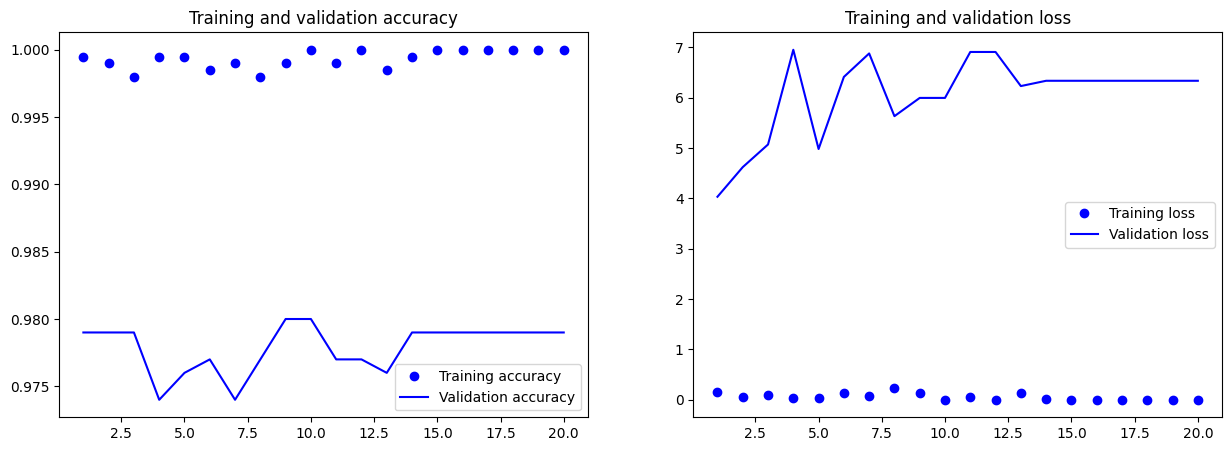

In [58]:
check_train_val_plot(history)

### 데이터 증식을 사용한 특성 추출

In [74]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [78]:
conv_base.trainable=True
print(len(conv_base.trainable_weights)) # 동결 전

26


In [80]:
conv_base.trainable=False
print(len(conv_base.trainable_weights)) # 동결 후

0


- 데이터 증식
- 동결된 합성곱 기반층
- 밀집분류기

In [83]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

# 입력층
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x) # 입력값의 스케일 조정

# 은닉층 = 합성곱 층 연결 (vgg16)
x = conv_base(x) # 합성곱 층 연결

# 출력층
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [84]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 11s 146ms/step - loss: 15.3494 - accuracy: 0.9055 - val_loss: 3.5403 - val_accuracy: 0.9630
Epoch 2/10
63/63 [==============================] - 10s 155ms/step - loss: 8.6891 - accuracy: 0.9395 - val_loss: 8.9493 - val_accuracy: 0.9510
Epoch 3/10
63/63 [==============================] - 11s 174ms/step - loss: 4.8446 - accuracy: 0.9580 - val_loss: 5.6608 - val_accuracy: 0.9610
Epoch 4/10
63/63 [==============================] - 9s 144ms/step - loss: 6.1591 - accuracy: 0.9550 - val_loss: 2.5642 - val_accuracy: 0.9820
Epoch 5/10
63/63 [==============================] - 9s 141ms/step - loss: 4.3680 - accuracy: 0.9655 - val_loss: 3.4569 - val_accuracy: 0.9710
Epoch 6/10
63/63 [==============================] - 9s 143ms/step - loss: 3.3584 - accuracy: 0.9665 - val_loss: 7.2962 - val_accuracy: 0.9670
Epoch 7/10
63/63 [==============================] - 10s 150ms/step - loss: 3.3852 - accuracy: 0.9745 - val_loss: 2.0618 - val_accuracy: 0.9830
E

### 평가

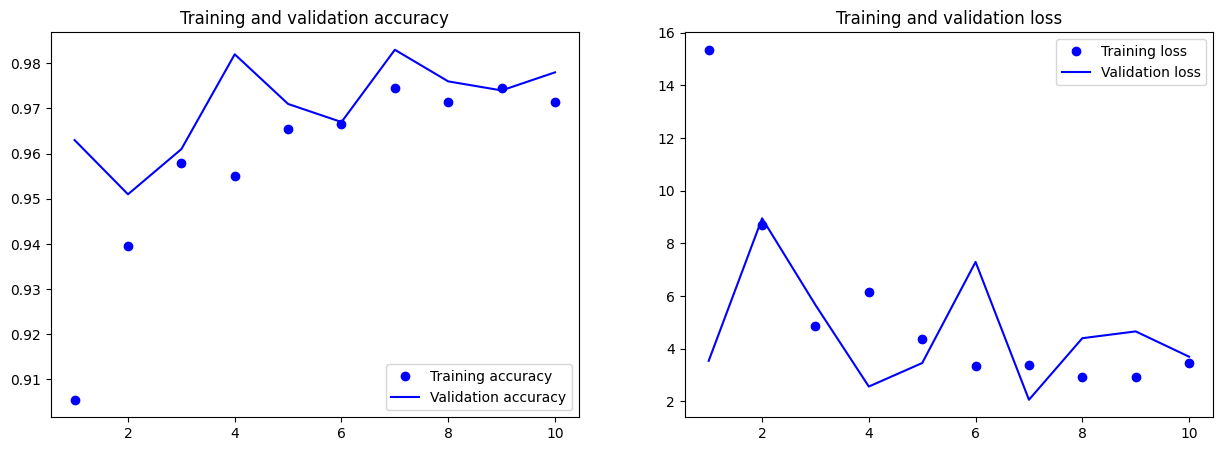

In [85]:
check_train_val_plot(history)

In [86]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras"
)

test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 6s 90ms/step - loss: 3.7093 - accuracy: 0.9765
테스트 정확도: 0.976


## 미세 조정하기

In [87]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

- 마지막 3개의 합성곱 층 미세조정(block5_conv1~3)

In [88]:
conv_base.trainable = True # 동결 전
for layer in conv_base.layers[:-4]:
  layer.trainable = False  # 동결 처음부터 ~ block4_pool 동결

In [89]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), # 미세조정 시, 학습률 숫자를 낮춘다 !
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 168ms/step - loss: 1.7918 - accuracy: 0.9815 - val_loss: 3.6303 - val_accuracy: 0.9740
Epoch 2/30
63/63 [==============================] - 11s 161ms/step - loss: 1.8413 - accuracy: 0.9785 - val_loss: 2.2942 - val_accuracy: 0.9820
Epoch 3/30
63/63 [==============================] - 10s 158ms/step - loss: 1.0328 - accuracy: 0.9810 - val_loss: 2.6755 - val_accuracy: 0.9810
Epoch 4/30
63/63 [==============================] - 10s 162ms/step - loss: 0.8556 - accuracy: 0.9830 - val_loss: 2.0492 - val_accuracy: 0.9830
Epoch 5/30
63/63 [==============================] - 11s 164ms/step - loss: 0.5736 - accuracy: 0.9890 - val_loss: 1.8777 - val_accuracy: 0.9820
Epoch 6/30
63/63 [==============================] - 10s 157ms/step - loss: 0.6438 - accuracy: 0.9885 - val_loss: 2.0757 - val_accuracy: 0.9840
Epoch 7/30
63/63 [==============================] - 10s 158ms/step - loss: 0.5897 - accuracy: 0.9880 - val_loss: 1.9666 - val_accuracy: 0.9830

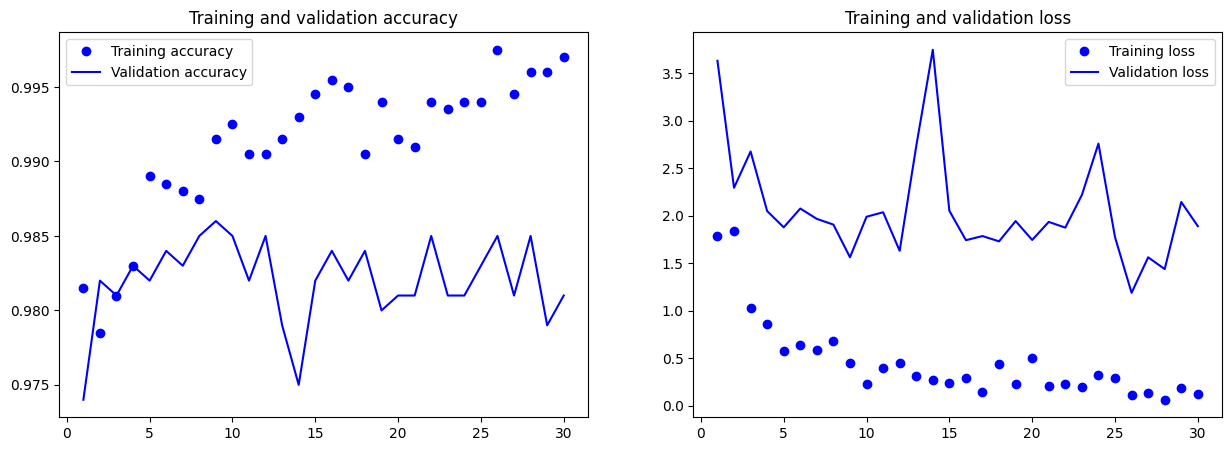

In [90]:
check_train_val_plot(history)

In [91]:
test_model = keras.models.load_model("fine_tuning.keras") # 저장된 모델 불러오기
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 7s 90ms/step - loss: 1.7630 - accuracy: 0.9780
테스트 정확도: 0.978
